## Evolution of the circuit along the time

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import subprocess
import sys
from pathlib import Path

import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from matplotlib import rc

import torch

sys.path.append(str(Path("..").resolve()))

from data import generate_data
from models.transformer import Transformer, TransformerConfig
from visualization.graph import build_graph

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

plt.rc("font", family="serif", size=8)

WIDTH = 8.5  # inches (from ICML style file)
HEIGHT = 8.5 / 1.5  # golden ratio

rc("font", family="serif", size=8)
usetex = not subprocess.run(["which", "pdflatex"]).returncode
rc("text", usetex=usetex)
if usetex:
    rc("text.latex", preamble=r"\usepackage{times}")

/home/vivc/.local/share/texlive/2022/bin/x86_64-linux/pdflatex


In [7]:
save_dir = Path("..").resolve() / "results"

# Generate data
vocab_size = 10
bsz = 32
length = 128
data = generate_data(vocab_size, bsz, length)

# Load model
config = TransformerConfig(
    vocab_size=vocab_size,
    emb_dim=512,
    seq_len=length,
    n_head=1,
    n_layer=2,
)
model = Transformer(config)
checkpoint = torch.load(save_dir / "Adam.pt", map_location=torch.device("cpu"))
model.load_state_dict(checkpoint)

# Recover attention matrices
with torch.no_grad():
    _, attns = model(data.to(torch.long), verbose=True)
    attns = attns.detach().cpu().numpy()
    data = data.numpy()

In [8]:
N = 10
attns1 = attns[0, :, 0, :N, :N]
attns2 = attns[1, :, 0, N - 1, :N]

In [9]:
# Create matrix with one on the subdiagonal
A = np.diagflat(np.ones(N - 1), k=-1)
attns1 = np.tile(A, (100, 1, 1))

Graph visualization

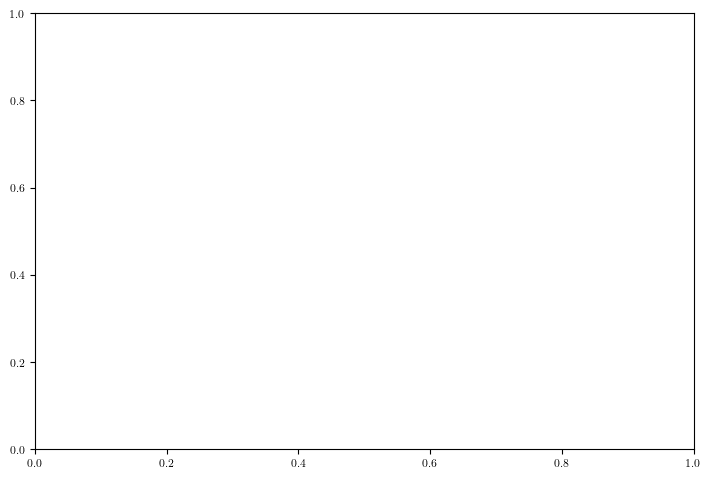

In [10]:
fig, ax = plt.subplots(figsize=(WIDTH, HEIGHT))
G, pos = build_graph(N)
magnifier = 5
weights = 0

data = data[:, :N]
current = data[:, -1]
ind = data == current[:, np.newaxis]


def update(frame):
    global weights

    # update variables
    ax.clear()
    old_weights = weights
    layer1 = attns1[frame]
    layer2 = attns2[frame]
    weights = np.hstack((layer1.T.flatten(), layer2))

    # color edges according to updates
    diff = weights - old_weights
    colors = ["green" if d > 0 else "red" for d in diff]

    # color similar nodes
    node_colors = ["lightgreen" if x else "lightcoral" for x in ind[frame]] + [
        "lightblue",
    ] * (N + 1)
    labels = (
        {f"0{i}": int(data[frame, i]) for i in range(N)}
        | {f"1{i}": "" for i in range(N)}
        | {"2": ""}
    )

    # draw the updated graph
    nx.draw(
        G,
        pos,
        width=magnifier * weights,
        with_labels=True,
        labels=labels,
        edge_color=colors,
        node_size=500,
        node_color=node_colors,
        ax=ax,
    )
    ax.set_title(f"Iteration {frame+1}", fontweight="bold")
    return


length = 10
ani = animation.FuncAnimation(fig, update, frames=length, repeat=False)
# ani.save("test.gif", writer="imagemagick", fps=5)
# ani.save("test.mp4", writer="ffmpeg", fps=1)